## Deep Q-Learning for Energy-Efficient Thruster Control in USV Navigation


In this notebook, we will explore the implementation of deep reinforcement learning (DRL) for energy-efficient navigation of an Unmanned Surface Vehicle (USV) with two thrusters in dynamic water environments. We evaluate the performance of various Deep Q-Network (DQN) variants – DQN, Double DQN, Dueling DQN, and Double Dueling DQN – under different scenarios, focusing on fuel optimization and the impact of flow fields. 


In [1]:
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [2]:
# To use in Kaggle we need to install these two packages
!pip install swig 
!pip install gym[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 8.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 2.3 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 44.6 MB/s eta 0:00:0000:0100:01
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=495634 sha256=5c2b61b2b9de35a79aee1d20539cc5719f04724e81fbd1d4b20535f0a1e46fa1
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


In [3]:
!git clone "https://github.com/suhanis16/RL-USV-Navigation.git"

Cloning into 'RL-USV-Navigation'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 99 (delta 54), reused 74 (delta 32), pack-reused 0
Receiving objects: 100% (99/99), 11.55 MiB | 30.40 MiB/s, done.
Resolving deltas: 100% (54/54), done.


In [4]:
import warnings
from typing import TYPE_CHECKING, Optional
import pickle
import numpy as np
import gym
from gym import spaces
from gym.error import DependencyNotInstalled
from gym.utils import EzPickle, colorize
from gym.utils.step_api_compatibility import step_api_compatibility

try:
    import Box2D
    from Box2D.b2 import (
        circleShape,
        edgeShape,
        fixtureDef,
        polygonShape,
    )
import pygame
from pygame import gfxdraw



FPS = 50
SCALE = 30.0

MAIN_ENGINE_POWER = 13.0
SIDE_ENGINE_POWER = 0.6

INITIAL_RANDOM = 1000.0  
LANDER_POLY = [(-14, +17), (-17, 0), (-17, -10), (+17, -10), (+17, 0), (+14, +17)]

SIDE_ENGINE_HEIGHT = 14.0
SIDE_ENGINE_AWAY = 12.0

VIEWPORT_W = 600
VIEWPORT_H = 400


class ThrusterNAAV(gym.Env, EzPickle):
    
    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": FPS,
    }

    def __init__(
        self,
        render_mode: Optional[str] = None,
        continuous: bool = False,
        gravity: float = 0.0,
        enable_wind: bool = False,
        wind_power: float = 15.0,
        turbulence_power: float = 1.5,
        start_pos: tuple = (2, 7),
        end_pos: tuple = (16, 7),
    ):
        EzPickle.__init__(
            self,
            render_mode,
            continuous,
            gravity,
            enable_wind,
            wind_power,
            turbulence_power,
        )

        self.gravity = gravity

        if 0.0 > wind_power or wind_power > 20.0:
            warnings.warn(
                colorize(
                    f"WARN: wind_power value is recommended to be between 0.0 and 20.0, (current value: {wind_power})",
                    "yellow",
                ),
            )
        self.wind_power = wind_power

        if 0.0 > turbulence_power or turbulence_power > 2.0:
            warnings.warn(
                colorize(
                    f"WARN: turbulence_power value is recommended to be between 0.0 and 2.0, (current value: {turbulence_power})",
                    "yellow",
                ),
            )
        self.turbulence_power = turbulence_power
        self.start_pos = start_pos
        self.end_pos = end_pos
        self.enable_wind = enable_wind
        self.wind_idx = np.random.randint(-9999, 9999)
        self.torque_idx = np.random.randint(-9999, 9999)

        self.screen: pygame.Surface = None
        self.clock = None
        self.isopen = True
        self.world = Box2D.b2World(gravity=[0.0, 0.0])
        self.moon = None
        self.lander: Optional[Box2D.b2Body] = None
        self.particles = []

        self.prev_reward = None

        self.continuous = continuous

        low = np.array(
            [
                -1.5,
                -1.5,
                -5.0,
                -5.0,
                -np.pi,
                -5.0,
                0.0,
            ]
        ).astype(np.float32)
        high = np.array(
            [
                1.5,
                1.5,
                5.0,
                5.0,
                np.pi,
                5.0,
                np.pi,
            ]
        ).astype(np.float32)

        self.observation_space = spaces.Box(low, high)

        if self.continuous:
            self.action_space = spaces.Box(-1, +1, (2,), dtype=np.float32)
        else:
            # Nop, fire left engine, main engine, right engine
            self.action_space = spaces.Discrete(4)

        self.render_mode = render_mode

    def _destroy(self):
        if not self.moon:
            return
        self.world.contactListener = None
        self._clean_particles(True)
        self.world.DestroyBody(self.moon)
        self.moon = None
        self.world.DestroyBody(self.lander)
        self.lander = None

    def _is_within_bounds(self):
        if 0 < self.lander.position[0] < 20 and 0 < self.lander.position[1] < 13:
            return True 
        return False

    def _goal_pos_reached(self):
        for fixture in self.lander.fixtures:
            if (fixture.TestPoint(self.end_pos)):
                return True
        return False

    def _generate_random_start_and_end_pos(self, grid_size=(20, 13), boundary_distance=3):
        # Randomly select start position near the boundaries
        start_pos_x = np.random.choice([0, grid_size[0]-1])
        start_pos_y = np.random.randint(boundary_distance, grid_size[1]-boundary_distance)
        start_pos = (start_pos_x, start_pos_y)
        
        # Determine initial angle of the lander based on the start position
        if start_pos_x == 0:
            init_angle = np.random.uniform(-np.pi, 0)
        else:
            init_angle = np.random.uniform(0, np.pi)
        
        # Select end position on the opposite boundary
        if start_pos_x == 0:
            end_pos_x = grid_size[0] - 1
        else:
            end_pos_x = 0
        end_pos_y = np.random.randint(boundary_distance, grid_size[1]-boundary_distance)
        end_pos = (end_pos_x, end_pos_y)
        
        self.start_pos = (int(start_pos[0]), int(start_pos[1]))
        self.end_pos = (int(end_pos[0]), int(end_pos[1]))
        self.init_angle = init_angle


    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        self._destroy()
        self.prev_shaping = None

        W = VIEWPORT_W / SCALE
        H = VIEWPORT_H / SCALE

        self.moon = self.world.CreateStaticBody(
            shapes=edgeShape(vertices=[(0, 0), (W, 0)])
        )
        self.moon.color1 = (0.0, 0.0, 0.0)
        self.moon.color2 = (0.0, 0.0, 0.0)

        self._generate_random_start_and_end_pos()

        self.lander: Box2D.b2Body = self.world.CreateDynamicBody(
            position = self.start_pos,
            angle=self.init_angle,
            fixtures=fixtureDef(
                shape=polygonShape(
                    vertices=[(x / SCALE, y / SCALE) for x, y in LANDER_POLY]
                ),
                density=5.0,
                friction=0.1,
                categoryBits=0x0010,
                maskBits=0x0000,  
                restitution=0.0,
            ), 
        )
        self.lander.color1 = (255, 255, 0)
        self.lander.color2 = (77, 77, 128)

        self.drawlist = [self.lander]

        if self.render_mode == "human":
            self.render()
        return self.step(np.array([0, 0]) if self.continuous else 0)[0], {}

    def _create_particle(self, mass, x, y, ttl):
        p = self.world.CreateDynamicBody(
            position=(x, y),
            angle=0.0,
            fixtures=fixtureDef(
                shape=circleShape(radius=2 / SCALE, pos=(0, 0)),
                density=mass,
                friction=0.1,
                categoryBits=0x0100,
                maskBits=0x001,  # collide only with ground
                restitution=0.3,
            ),
        )
        p.ttl = ttl
        self.particles.append(p)
        self._clean_particles(False)
        return p

    def _clean_particles(self, all):
        while self.particles and (all or self.particles[0].ttl < 0):
            self.world.DestroyBody(self.particles.pop(0))

    def _angle_with_goal(self, pos):
        agent_orientation = np.array([np.sin(self.lander.angle), np.cos(self.lander.angle)])
        goal_vector = np.array([self.end_pos[0] - pos[0], self.end_pos[1] - pos[1]])
        angle_with_goal = np.arccos(np.dot(agent_orientation, goal_vector) / (np.linalg.norm(agent_orientation) * np.linalg.norm(goal_vector)))
        angle_with_goal -= np.pi
        return -angle_with_goal

    def step(self, action):
        assert self.lander is not None

        # Update wind
        assert self.lander is not None, "You forgot to call reset()"
        if self.enable_wind:
            # the function used for wind is tanh(sin(2 k x) + sin(pi k x)),
            # which is proven to never be periodic, k = 0.01
            wind_mag = (
                np.tanh(
                    np.sin(0.02 * self.wind_idx)
                    + (np.sin(np.pi * 0.01 * self.wind_idx))
                )
                * self.wind_power
            )
            self.wind_idx += 1
            self.lander.ApplyForceToCenter(
                (wind_mag, 0.0),
                True,
            )

            # the function used for torque is tanh(sin(2 k x) + sin(pi k x)),
            # which is proven to never be periodic, k = 0.01
            torque_mag = np.tanh(
                np.sin(0.02 * self.torque_idx)
                + (np.sin(np.pi * 0.01 * self.torque_idx))
            ) * (self.turbulence_power)
            self.torque_idx += 1
            self.lander.ApplyTorque(
                (torque_mag),
                True,
            )

        if self.continuous:
            action = np.clip(action, -1, +1).astype(np.float32)
        else:
            assert self.action_space.contains(
                action
            ), f"{action!r} ({type(action)}) invalid "

        # Engines
        tip = (np.sin(self.lander.angle), np.cos(self.lander.angle))
        side = (-tip[1], tip[0])
        dispersion = [self.np_random.uniform(-1.0, +1.0) / SCALE for _ in range(2)]

        m_power = 0.0
        if (self.continuous and action[0] > 0.0) or (
            not self.continuous and action == 2
        ):
            # Main engine
            if self.continuous:
                m_power = (np.clip(action[0], 0.0, 1.0) + 1.0) * 0.5  # 0.5..1.0
                assert m_power >= 0.5 and m_power <= 1.0
            else:
                m_power = 1.0
            # 4 is move a bit downwards, +-2 for randomness
            ox = tip[0] * (4 / SCALE + 2 * dispersion[0]) + side[0] * dispersion[1]
            oy = -tip[1] * (4 / SCALE + 2 * dispersion[0]) - side[1] * dispersion[1]
            impulse_pos = (self.lander.position[0] + ox, self.lander.position[1] + oy)
            p = self._create_particle(
                3.5,  
                impulse_pos[0],
                impulse_pos[1],
                m_power,
            ) 
            p.ApplyLinearImpulse(
                (ox * MAIN_ENGINE_POWER * m_power, oy * MAIN_ENGINE_POWER * m_power),
                impulse_pos,
                True,
            )
            self.lander.ApplyLinearImpulse(
                (-ox * MAIN_ENGINE_POWER * m_power, -oy * MAIN_ENGINE_POWER * m_power),
                impulse_pos,
                True,
            )

        s_power = 0.0
        if (self.continuous and np.abs(action[1]) > 0.5) or (
            not self.continuous and action in [1, 3]
        ):
            # Orientation engines
            if self.continuous:
                direction = np.sign(action[1])
                s_power = np.clip(np.abs(action[1]), 0.5, 1.0)
                assert s_power >= 0.5 and s_power <= 1.0
            else:
                direction = action - 2
                s_power = 1.0
            ox = tip[0] * dispersion[0] + side[0] * (
                3 * dispersion[1] + direction * SIDE_ENGINE_AWAY / SCALE
            )
            oy = -tip[1] * dispersion[0] - side[1] * (
                3 * dispersion[1] + direction * SIDE_ENGINE_AWAY / SCALE
            )
            impulse_pos = (
                self.lander.position[0] + ox - tip[0] * 17 / SCALE,
                self.lander.position[1] + oy + tip[1] * SIDE_ENGINE_HEIGHT / SCALE,
            )
            p = self._create_particle(0.7, impulse_pos[0], impulse_pos[1], s_power)
            p.ApplyLinearImpulse(
                (ox * SIDE_ENGINE_POWER * s_power, oy * SIDE_ENGINE_POWER * s_power),
                impulse_pos,
                True,
            )
            self.lander.ApplyLinearImpulse(
                (-ox * SIDE_ENGINE_POWER * s_power, -oy * SIDE_ENGINE_POWER * s_power),
                impulse_pos,
                True,
            )

        self.world.Step(1.0 / FPS, 6 * 30, 2 * 30)

        pos = self.lander.position
        vel = self.lander.linearVelocity
        state = [
            (pos.x - self.end_pos[0]),
            (pos.y - self.end_pos[1]),
            vel.x * (VIEWPORT_W / SCALE / 2) / FPS,
            vel.y * (VIEWPORT_H / SCALE / 2) / FPS,
            self.lander.angle,
            20.0 * self.lander.angularVelocity / FPS,
            self._angle_with_goal(pos),
        ]
        assert len(state) == 7

        reward = 0
        shaping = (
            -100 * np.sqrt(state[0] * state[0] + state[1] * state[1])
            - 100 * np.sqrt(state[2] * state[2] + state[3] * state[3])
            - 100 * abs(state[6])
        )  
        if self.prev_shaping is not None:
            reward = shaping - self.prev_shaping
        self.prev_shaping = shaping

        # calculate fuel spent
        fuel = m_power + s_power

        terminated = False
        if not self._is_within_bounds():
            terminated = True
            reward = -100
        if self._goal_pos_reached():
            terminated = True
            reward += 1000
        if not self.lander.awake:
            terminated = True
            reward = -100

        if self.render_mode == "human":
            self.render()

        return np.array(state, dtype=np.float32), reward, terminated, False, {'fuel': fuel}

    def render(self):
        if self.render_mode is None:
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
            )
            return

        if self.screen is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.screen = pygame.display.set_mode((VIEWPORT_W, VIEWPORT_H))
        if self.clock is None:
            self.clock = pygame.time.Clock()
        self.surf = pygame.Surface((VIEWPORT_W, VIEWPORT_H))

        pygame.transform.scale(self.surf, (SCALE, SCALE))
        pygame.draw.rect(self.surf, (79, 66, 181), self.surf.get_rect())

        # Draw start and end markers
        pygame.draw.circle(self.surf, (255, 0, 0), (self.start_pos[0]*SCALE, self.start_pos[1]*SCALE), 10)
        pygame.draw.circle(self.surf, (0, 255, 0), (self.end_pos[0]*SCALE, self.end_pos[1]*SCALE), 10)

        for obj in self.particles:
            obj.ttl -= 0.15
            obj.color1 = (
                int(max(0.2, 0.15 + obj.ttl) * 255),
                int(max(0.2, 0.5 * obj.ttl) * 255),
                int(max(0.2, 0.5 * obj.ttl) * 255),
            )
            obj.color2 = (
                int(max(0.2, 0.15 + obj.ttl) * 255),
                int(max(0.2, 0.5 * obj.ttl) * 255),
                int(max(0.2, 0.5 * obj.ttl) * 255),
            )

        self._clean_particles(False)

        for obj in self.particles + self.drawlist:
            for f in obj.fixtures:
                trans = f.body.transform
                if type(f.shape) is circleShape:
                    pygame.draw.circle(
                        self.surf,
                        color=obj.color1,
                        center=trans * f.shape.pos * SCALE,
                        radius=f.shape.radius * SCALE,
                    )
                    pygame.draw.circle(
                        self.surf,
                        color=obj.color2,
                        center=trans * f.shape.pos * SCALE,
                        radius=f.shape.radius * SCALE,
                    )

                else:
                    path = [trans * v * SCALE for v in f.shape.vertices]
                    pygame.draw.polygon(self.surf, color=obj.color1, points=path)
                    gfxdraw.aapolygon(self.surf, path, obj.color1)
                    pygame.draw.aalines(
                        self.surf, color=obj.color2, points=path, closed=True
                    )

        self.surf = pygame.transform.flip(self.surf, False, True)

        if self.render_mode == "human":
            assert self.screen is not None
            self.screen.blit(self.surf, (0, 0))
            pygame.event.pump()
            self.clock.tick(self.metadata["render_fps"])
            pygame.display.flip()
        elif self.render_mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.surf)), axes=(1, 0, 2)
            )

    def close(self):
        if self.screen is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()
            self.isopen = False


def play_DQN_episode(env, agent):
    score = 0
    state, _ = env.reset(seed=42)
    fuel = 0
    
    while True:
        # eps=0 for predictions
        action = agent.act(state, 0)
        state, reward, terminated, truncated, info = env.step(action) 
        done = terminated or truncated
        fuel += info['fuel']

        score += reward
        
        env.render()

        # End the episode if done
        if done:
            break 

    return score, fuel

## The DQN Algorithm:

In [5]:
import torch

class DQN(torch.nn.Module):

    def __init__(self, state_size=6, action_size=4, hidden_size=64):
        super(DQN, self).__init__()
        self.layer1 = torch.nn.Linear(state_size, hidden_size)
        self.layer2 = torch.nn.Linear(hidden_size, hidden_size)
        self.layer3 = torch.nn.Linear(hidden_size, action_size)

    def forward(self, state):
        x = torch.relu(self.layer1(state))
        x = torch.relu(self.layer2(x))
        return self.layer3(x)

### Defining the Replay Buffer


In [6]:
import numpy as np
import random
from collections import deque

class ReplayBuffer:
    def __init__(self, buffer_size=10000):
        self.buffer = deque(maxlen=buffer_size)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return np.stack(states), actions, rewards, np.stack(next_states), dones

    def __len__(self):
        return len(self.buffer)

### Define the DQN Agent

In [7]:
class DQNAgent:
    def __init__(self, state_size=6, action_size=4, hidden_size=64, 
                 learning_rate=1e-3, gamma=0.99, buffer_size=10000, batch_size=64):

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gamma = gamma

        self.batch_size = batch_size
        self.action_size = action_size

        # Initialize the Q-Network and Target Network with the given state size, action size and hidden layer size
        self.q_network = DQN(state_size, action_size, hidden_size).to(self.device)
        self.target_network = DQN(state_size, action_size, hidden_size).to(self.device)
        
        # Set weights of target network to be the same as those of the q network
        self.target_network.load_state_dict(self.q_network.state_dict())
        
        # Set target network to evaluation mode
        self.target_network.eval()

        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.memory = ReplayBuffer(buffer_size)

    def step(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)
        
        # If there are enough experiences in memory, perform a learning step
        if len(self.memory) > self.batch_size:
            self.update_model()

    def act(self, state, eps=0.):
        if random.random() > eps:  
            state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)  
            self.q_network.eval()  

            # With no gradient updates, get the action values from the DQN
            with torch.no_grad():
                action_values = self.q_network(state)

            self.q_network.train() 
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))  
        
    def update_model(self):
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        # Convert numpy arrays to PyTorch tensors
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(np.array(actions)).long().to(self.device)
        rewards = torch.from_numpy(np.array(rewards)).float().to(self.device)
        next_states = torch.from_numpy(next_states).float().to(self.device)
        dones = torch.from_numpy(np.array(dones).astype(np.uint8)).float().to(self.device)

        # Get Q-values for the actions that were actually taken
        q_values = self.q_network(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)
        
        # Get maximum Q-value for the next states from target network
        next_q_values = self.target_network(next_states).max(1)[0].detach()
        
        # Compute the expected Q-values
        expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        # Compute the loss between the current and expected Q values
        loss = torch.nn.MSELoss()(q_values, expected_q_values)
        
        # Zero all gradients
        self.optimizer.zero_grad()
        
        # Backpropagate the loss
        loss.backward()
        
        # Step the optimizer
        self.optimizer.step()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

### Training the Agent

In [9]:
def train(agent, env, n_episodes=2500, eps_start=1.0, eps_end=0.01, eps_decay=0.995, target_update=10):
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start

    for i_episode in range(1, n_episodes + 1):
        state, _ = env.reset()
        score = 0 

        while True:
            action = agent.act(state, eps)
            next_state, reward, terminated, truncated, _ = env.step(action) 
            done = terminated or truncated
            agent.step(state, action, reward, next_state, done)
            state = next_state 
            score += reward

            if done:
                break 
        
        scores_window.append(score)
        scores.append(score) 

        eps = max(eps_end, eps_decay * eps)
        print(f"\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}", end="")

        if i_episode % target_update == 0:
            agent.update_target_network()

        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))

    return scores


env = ThrusterNAAV()
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

agent = DQNAgent(state_size, action_size)

scores = train(agent, env)

Episode 100	Average Score: 220.68
Episode 200	Average Score: 249.19
Episode 300	Average Score: 367.45
Episode 400	Average Score: 356.56
Episode 500	Average Score: 476.42
Episode 600	Average Score: 821.40
Episode 700	Average Score: 1051.93
Episode 800	Average Score: 1323.98
Episode 900	Average Score: 1505.07
Episode 1000	Average Score: 1497.41
Episode 1100	Average Score: 1464.12
Episode 1200	Average Score: 1702.97
Episode 1300	Average Score: 1677.79
Episode 1400	Average Score: 1602.92
Episode 1500	Average Score: 1120.41
Episode 1600	Average Score: 1371.79
Episode 1700	Average Score: 1248.20
Episode 1800	Average Score: 1153.54
Episode 1900	Average Score: 1407.20
Episode 2000	Average Score: 1142.14
Episode 2100	Average Score: 1493.88
Episode 2200	Average Score: 1185.05
Episode 2300	Average Score: 1368.01
Episode 2400	Average Score: 1263.41
Episode 2500	Average Score: 1329.09


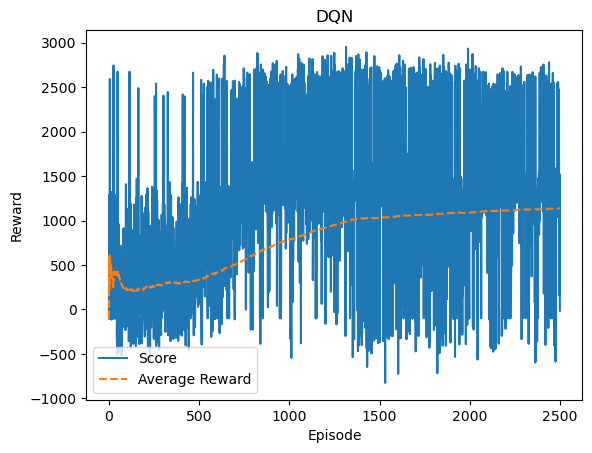

In [10]:
import matplotlib.pyplot as plt

# Assuming 'scores' contains the rewards for each episode
# Calculate the average reward for each episode
average_rewards = [sum(scores[:i+1]) / len(scores[:i+1]) for i in range(len(scores))]

# Plot both scores and average rewards
plt.plot(scores, label='Score')
plt.plot(average_rewards, label='Average Reward', linestyle='--')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.title('DQN')
plt.show()

In [11]:
# save model
import pickle
with open('agent_DQN.pkl', 'wb') as f:
    pickle.dump(agent, f)

## Double DQN (DDQN)

In [12]:
class DDQNAgent:
    def __init__(self, state_size=8, action_size=4, hidden_size=64, 
                 learning_rate=1e-3, gamma=0.99, buffer_size=10000, batch_size=64):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gamma = gamma
        self.batch_size = batch_size
        self.action_size = action_size
        self.q_network = DQN(state_size, action_size, hidden_size).to(self.device)
        self.target_network = DQN(state_size, action_size, hidden_size).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.memory = ReplayBuffer(buffer_size)

    def step(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)
        if len(self.memory) > self.batch_size:
            self.update_model()

    def act(self, state, eps=0.):
        if random.random() > eps: 
            state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)  
            self.q_network.eval() 
            with torch.no_grad():
                action_values = self.q_network(state)
            self.q_network.train() 
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))  
        
    def update_model(self):

        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(np.array(actions)).long().to(self.device)
        rewards = torch.from_numpy(np.array(rewards)).float().to(self.device)
        next_states = torch.from_numpy(next_states).float().to(self.device)
        dones = torch.from_numpy(np.array(dones).astype(np.uint8)).float().to(self.device)

        # Get Q-values for the actions that were actually taken
        q_values = self.q_network(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)

        # Get the action values from the online network
        next_action_values = self.q_network(next_states).max(1)[1].unsqueeze(-1)

        # Get the Q-values from the target network for the actions chosen by the Q-network
        next_q_values = self.target_network(next_states).gather(1, next_action_values).detach().squeeze(-1)
        
        # Compute the expected Q-values
        expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        # Compute the loss between the current and expected Q values
        loss = torch.nn.MSELoss()(q_values, expected_q_values)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

env = ThrusterNAAV()
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

agent = DDQNAgent(state_size, action_size)

scores = train(agent, env)

# Play a demonstration episode
score = play_DQN_episode(env, agent)
print("Score obtained:", score)

Episode 100	Average Score: 163.65
Episode 200	Average Score: 549.39
Episode 300	Average Score: 526.07
Episode 400	Average Score: 551.24
Episode 500	Average Score: 740.73
Episode 600	Average Score: 900.64
Episode 700	Average Score: 1091.62
Episode 800	Average Score: 1250.03
Episode 900	Average Score: 1342.35
Episode 1000	Average Score: 1534.72
Episode 1100	Average Score: 1661.49
Episode 1200	Average Score: 1672.88
Episode 1300	Average Score: 1407.70
Episode 1400	Average Score: 1570.61
Episode 1500	Average Score: 1694.15
Episode 1600	Average Score: 1561.43
Episode 1700	Average Score: 1570.60
Episode 1800	Average Score: 1842.66
Episode 1900	Average Score: 1863.94
Episode 2000	Average Score: 1823.10
Episode 2100	Average Score: 1695.56
Episode 2200	Average Score: 1876.81
Episode 2300	Average Score: 1661.44
Episode 2400	Average Score: 1606.48
Episode 2500	Average Score: 1446.56
Score obtained: (1210.8575746205483, 104.0)


/tmp/ipykernel_32/2294510459.py:559: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, 
  gym.logger.warn(


In [13]:
# save model
import pickle
with open('agent_DDQN.pkl', 'wb') as f:
    pickle.dump(agent, f)

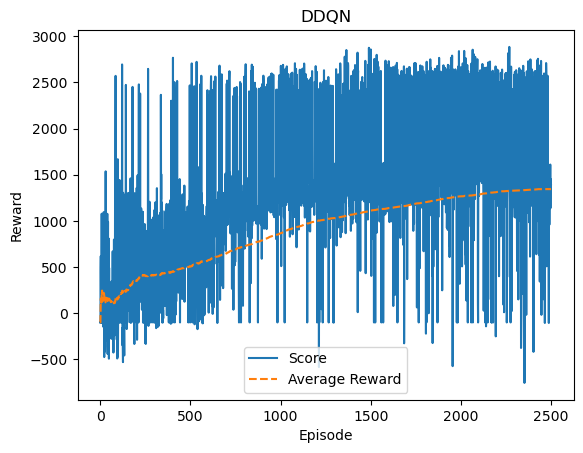

In [14]:
import matplotlib.pyplot as plt

# Assuming 'scores' contains the rewards for each episode
# Calculate the average reward for each episode
average_rewards = [sum(scores[:i+1]) / len(scores[:i+1]) for i in range(len(scores))]

# Plot both scores and average rewards
plt.plot(scores, label='Score')
plt.plot(average_rewards, label='Average Reward', linestyle='--')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.title('DDQN')
plt.show()

## Dueling Deep Q-Networks (Dueling DQN)

In [15]:
import torch 
class DuelingDQN(torch.nn.Module):

    def __init__(self, state_size=8, action_size=4, hidden_size=64):
 
        super(DuelingDQN, self).__init__()
        self.layer1 = torch.nn.Linear(state_size, hidden_size)
        self.layer2 = torch.nn.Linear(hidden_size, hidden_size)
        self.advantage = torch.nn.Linear(hidden_size, action_size)
        self.value = torch.nn.Linear(hidden_size, 1)

    def forward(self, state):

        # Common part of the network
        x = torch.relu(self.layer1(state))
        x = torch.relu(self.layer2(x))

        # Streams split here
        advantage = self.advantage(x)
        value = self.value(x)

        # Recombine advantage and value for Q
        return value + (advantage - advantage.max(dim=1, keepdim=True)[0])
    

class DuelingDQNAgent:

    def __init__(self, state_size=8, action_size=4, hidden_size=64, 
                 learning_rate=1e-3, gamma=0.99, buffer_size=10000, batch_size=64):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gamma = gamma
        self.batch_size = batch_size
        self.action_size = action_size

        # Use the dueling DQN networks instead
        self.q_network = DuelingDQN(state_size, action_size, hidden_size).to(self.device)
        self.target_network = DuelingDQN(state_size, action_size, hidden_size).to(self.device)

        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.memory = ReplayBuffer(buffer_size)

    def step(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)
        if len(self.memory) > self.batch_size:
            self.update_model()

    def act(self, state, eps=0.):
        if random.random() > eps:  
            state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)  
            self.q_network.eval()
            with torch.no_grad():
                action_values = self.q_network(state)
            self.q_network.train() 
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))  
        
    def update_model(self):
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(np.array(actions)).long().to(self.device)
        rewards = torch.from_numpy(np.array(rewards)).float().to(self.device)
        next_states = torch.from_numpy(next_states).float().to(self.device)
        dones = torch.from_numpy(np.array(dones).astype(np.uint8)).float().to(self.device)
        q_values = self.q_network(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)
        next_q_values = self.target_network(next_states).max(1)[0].detach()
        expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)
        loss = torch.nn.MSELoss()(q_values, expected_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

# Make an environment
env = ThrusterNAAV()
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Initilize a DuelingDQN agent
agent = DuelingDQNAgent(state_size, action_size)
scores = train(agent, env)

# Play a demonstration episode
score = play_DQN_episode(env, agent)
print("Score obtained:", score)

Episode 100	Average Score: 179.26
Episode 200	Average Score: 487.13
Episode 300	Average Score: 563.71
Episode 400	Average Score: 650.16
Episode 500	Average Score: 824.30
Episode 600	Average Score: 1028.13
Episode 700	Average Score: 1222.28
Episode 800	Average Score: 1355.38
Episode 900	Average Score: 1567.05
Episode 1000	Average Score: 1389.52
Episode 1100	Average Score: 1465.34
Episode 1200	Average Score: 1562.06
Episode 1300	Average Score: 1720.45
Episode 1400	Average Score: 1836.55
Episode 1500	Average Score: 1505.62
Episode 1600	Average Score: 1563.25
Episode 1700	Average Score: 1710.00
Episode 1800	Average Score: 1384.26
Episode 1900	Average Score: 1396.29
Episode 2000	Average Score: 1349.09
Episode 2100	Average Score: 1119.55
Episode 2200	Average Score: 1118.29
Episode 2300	Average Score: 1343.71
Episode 2400	Average Score: 1395.73
Episode 2500	Average Score: 1295.92
Score obtained: (1161.7702122660617, 85.0)


/tmp/ipykernel_32/2294510459.py:559: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, 
  gym.logger.warn(


In [16]:
# save model
import pickle
with open('agent_dueling.pkl', 'wb') as f:
    pickle.dump(agent, f)

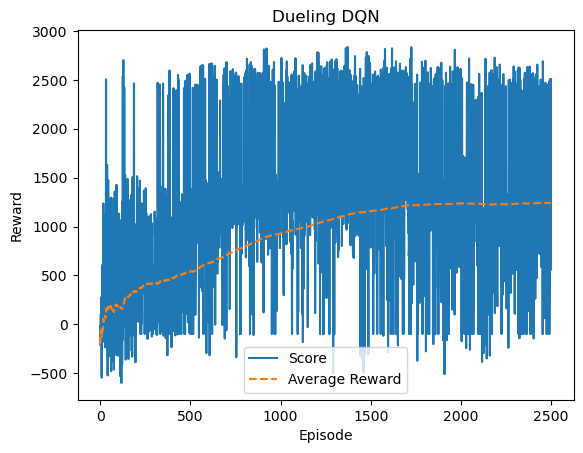

In [17]:
import matplotlib.pyplot as plt

# Assuming 'scores' contains the rewards for each episode
# Calculate the average reward for each episode
average_rewards = [sum(scores[:i+1]) / len(scores[:i+1]) for i in range(len(scores))]

# Plot both scores and average rewards
plt.plot(scores, label='Score')
plt.plot(average_rewards, label='Average Reward', linestyle='--')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.title('Dueling DQN')
plt.show()

## Double Dueling Deep Q-Networks (Dueling DQN)

In [18]:
import torch 
class DuelingDQN(torch.nn.Module):

    def __init__(self, state_size=8, action_size=4, hidden_size=64):
 
        super(DuelingDQN, self).__init__()

        # Common layers
        self.layer1 = torch.nn.Linear(state_size, hidden_size)
        self.layer2 = torch.nn.Linear(hidden_size, hidden_size)

        # Advantage layer
        self.advantage = torch.nn.Linear(hidden_size, action_size)

        # Value layer
        self.value = torch.nn.Linear(hidden_size, 1)

    def forward(self, state):

        # Common part of the network
        x = torch.relu(self.layer1(state))
        x = torch.relu(self.layer2(x))

        # Streams split here
        advantage = self.advantage(x)
        value = self.value(x)

        # Recombine advantage and value for Q
        return value + (advantage - advantage.max(dim=1, keepdim=True)[0])
    

class DuelingDQNAgent:

    def __init__(self, state_size=8, action_size=4, hidden_size=64, 
                 learning_rate=1e-3, gamma=0.99, buffer_size=10000, batch_size=64):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gamma = gamma
        self.batch_size = batch_size
        self.action_size = action_size

        # Use the dueling DQN networks instead
        self.q_network = DuelingDQN(state_size, action_size, hidden_size).to(self.device)
        self.target_network = DuelingDQN(state_size, action_size, hidden_size).to(self.device)

        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.memory = ReplayBuffer(buffer_size)

    def step(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)
        if len(self.memory) > self.batch_size:
            self.update_model()

    def act(self, state, eps=0.):
        if random.random() > eps:  
            state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)  
            self.q_network.eval()
            with torch.no_grad():
                action_values = self.q_network(state)
            self.q_network.train() 
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))  
        
    def update_model(self):
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(np.array(actions)).long().to(self.device)
        rewards = torch.from_numpy(np.array(rewards)).float().to(self.device)
        next_states = torch.from_numpy(next_states).float().to(self.device)
        dones = torch.from_numpy(np.array(dones).astype(np.uint8)).float().to(self.device)
        q_values = self.q_network(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)
        next_q_values = self.target_network(next_states).max(1)[0].detach()
        expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)
        loss = torch.nn.MSELoss()(q_values, expected_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

In [19]:
class D3QNAgent:
    def __init__(self, state_size=8, action_size=4, hidden_size=64, 
                 learning_rate=1e-3, gamma=0.99, buffer_size=10000, batch_size=64):

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gamma = gamma
        self.batch_size = batch_size
        self.action_size = action_size
        self.q_network = DuelingDQN(state_size, action_size, hidden_size).to(self.device)
        self.target_network = DuelingDQN(state_size, action_size, hidden_size).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.memory = ReplayBuffer(buffer_size)

    def step(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)
        if len(self.memory) > self.batch_size:
            self.update_model()

    def act(self, state, eps=0.):
        if random.random() > eps:  
            state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)  
            self.q_network.eval()  
            with torch.no_grad():
                action_values = self.q_network(state)

            self.q_network.train() 
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))  
        
    def update_model(self):
        # Sample a batch of experiences from memory
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        # Convert numpy arrays to PyTorch tensors
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(np.array(actions)).long().to(self.device)
        rewards = torch.from_numpy(np.array(rewards)).float().to(self.device)
        next_states = torch.from_numpy(next_states).float().to(self.device)
        dones = torch.from_numpy(np.array(dones).astype(np.uint8)).float().to(self.device)

        # Get Q-values for the actions that were actually taken
        q_values = self.q_network(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)

        # Get the action values from the online network
        next_action_values = self.q_network(next_states).max(1)[1].unsqueeze(-1)

        # Get the Q-values from the target network for the actions chosen by the Q-network
        next_q_values = self.target_network(next_states).gather(1, next_action_values).detach().squeeze(-1)
        
        # Compute the expected Q-values
        expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        # Compute the loss between the current and expected Q values
        loss = torch.nn.MSELoss()(q_values, expected_q_values)
        
        # Zero all gradients
        self.optimizer.zero_grad()
        
        # Backpropagate the loss
        loss.backward()
        
        # Step the optimizer
        self.optimizer.step()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

# Make an environment
env = ThrusterNAAV()
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Initilize a D3QN agent
agent = D3QNAgent(state_size, action_size)

# Train it
scores = train(agent, env)

# Play a demonstration episode
score = play_DQN_episode(env, agent)
print("Score obtained:", score)

Episode 100	Average Score: 244.65
Episode 200	Average Score: 233.69
Episode 300	Average Score: 320.51
Episode 400	Average Score: 325.64
Episode 500	Average Score: 406.33
Episode 600	Average Score: 465.24
Episode 700	Average Score: 570.92
Episode 800	Average Score: 596.62
Episode 900	Average Score: 658.92
Episode 1000	Average Score: 715.72
Episode 1100	Average Score: 709.90
Episode 1200	Average Score: 658.87
Episode 1300	Average Score: 987.17
Episode 1400	Average Score: 874.436
Episode 1500	Average Score: 973.484
Episode 1600	Average Score: 893.721
Episode 1700	Average Score: 870.92
Episode 1800	Average Score: 1075.12
Episode 1900	Average Score: 1143.44
Episode 2000	Average Score: 1318.05
Episode 2100	Average Score: 1004.99
Episode 2200	Average Score: 1095.11
Episode 2300	Average Score: 1386.31
Episode 2400	Average Score: 1310.14
Episode 2500	Average Score: 1312.82
Score obtained: (985.0208852555756, 123.0)


/tmp/ipykernel_32/2294510459.py:559: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, 
  gym.logger.warn(


In [20]:
# save model
import pickle
with open('agent_Ddueling.pkl', 'wb') as f:
    pickle.dump(agent, f)

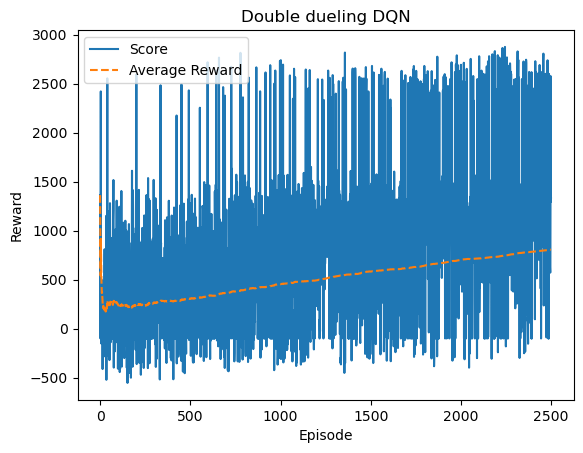

In [21]:
import matplotlib.pyplot as plt

# Assuming 'scores' contains the rewards for each episode
# Calculate the average reward for each episode
average_rewards = [sum(scores[:i+1]) / len(scores[:i+1]) for i in range(len(scores))]

# Plot both scores and average rewards
plt.plot(scores, label='Score')
plt.plot(average_rewards, label='Average Reward', linestyle='--')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.title('Double dueling DQN')
plt.show()